## cocoCity - Final Project

### Setup

In [1]:
%env SUMO_HOME=/usr/share/sumo 
# DO NOT TOUCH THE ABOVE LINE: needed for SUMO, which supports the traffic simulation

import os,sys,json,argparse
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import pandas as pd
import importlib
import time

# import necessary modules # src is short for "source code", and is a folder that you are given

# The following package is used to estimate the macroscopic fundamental diagram
from src.tasks.estimate import Estimate # Used to estimate the macroscopic fundamental diagram
from src.simulations.testcontrolsim import test_ControlSim # (helper function, can be ignored)

# The following packages are for simulation and control design
from src.tasks.dsl import DSL # DSL is the class used for Dynamic Speed Limit control which runs a ControlSim simulation with Controller in the loop
from src.controllers.controller import Controller # An abstract class for the controllers implemented which determine the dynamic speed limits
from src.simulations.controlsim import ControlSim # A simulation environment in which we test our controllers

# The following packages are for visualization
from src.visualization.visualization import *
from src.data.comparison import Comparison
from src.data.experiment import Experiment

# Load the parameters of the simulation
taskparams_json = "dep/sumo_files/cocoCity/simparams/cocoCity.json"
with open(taskparams_json,'r') as file:
    taskparams = json.load(file)
mfd_taskparams = "dep/sumo_files/cocoCity/simparams/cocoCity_mfd.json"
with open(mfd_taskparams,'r') as file:
    mfd_taskparams = json.load(file)

env: SUMO_HOME=/usr/share/sumo


### Traffic Inflow Problem

You are a control engineer hired by COCO City to improve the flow of traffic in COCO City during the morning rush hour.

#### COCO City's Traffic Grid

The COCO City traffic grid is divided into 5 regions including the periphery regions (Regions 0 to 3) and the city-center region (Region 4).

The 5 roads leading from the periphery regions to the center region (in black) have Dynamic Speed Limit (DSL) functionality that allows COCO City to adjust the speed limits on those roads in real-time.

<img src="figs/COCOcityImage.png" width="800">

The control levers are the dynamic speed limits (DSLs) of the five roads leading to the center region (the black roads numbered 0-4 in the figure above). Each DSL control lever is a number between 0.5 and 1.5 which multiplies the nominal speed limit of 50 km/h to determine the DSL for the given road.

COCO City has hired you to design an algorithm which takes in 1) the densities of the cars on the road and 2) the forecast of the cars that will spawn in each region in the coming timesteps and determines the DSLs for the five roads leading into the city center.

### COCO City provides you with the following

#### A Simulation of Urban MObility (SUMO) traffic simulator with code to implement their basic controller

SimUlation of Urban Mobility (SUMO) is an open-source traffic simulation package which runs a "microscopic" traffic simulation that allows for control of specific cars, and lights, speed limits. In this project, our code interfaces with the SUMO simulator via DSLs and measures density for each region, the number of vehicles travelled, travel time, CO2 emissions, and a few other metrics.

Each simulation timestep corresponds to 20 seconds of wall-clock time.

When COCO City's controller is running, the code interfaces with SUMO to start and stop simulations and to control road speed limits at each simulation step. The code is object-oriented. "tasks" are abstract classes which support subclasses such as a "DSL" task, which run a DSL-control simulation. When a task is instantiated, the code creates a simulation of the traffic network with details specified in the task parameters/function inputs.

A DSL task creates a simulation object called ControlSim, which contains functionality to run the DSL traffic system simulation while continuously adjusting speed limits on specific roads with control logic that you define. The specifics for how to implement a new controller are given in the "How to implement a controller" section below.


                                                                                                                                                                                                                                                                                                                                                                                   

#### The optimal densities for each region, derived from the Macroscopic Fundamental Diagrams (MFDs)

Research on traffic systems shows that maximum flow is reached at a certain density of cars---when density is too low there are few cars flowing through the network, and when density is too high traffic jams arise, impeding the speed at which vehicles travel. The function mapping density to flow is called the Macroscopic Fundamental Diagram (MFD). The maximum flow occurs at a certain optimal density $\rho^*$. 

COCO City's objective is to maximize the flow of vehicles through the city by adjusting the DSLs up or down. DSLs directly affect the density in a given region, as the change in the number of cars in a given region depends on the speed limits of the roads that enter the region.

The mapping between densities and flows, however, is nonlinear. Thus, it is common in traffic control to track the optimal density for a given region, rather than maximizing flow.

With this in mind, COCO City has run experiments to determine the MFD for their city and gathered the following data for the center region/Region 4 (similar plots are available for regions 0-3). 

<img src="figs/MFD_COCOcity_centerRegion.png" width="600">

From the gathered data, it is evident that the optimal densities are approximately 5.70, 9.83, 10.63, 14.55, and 11.94 for regions 0-4, respectively.

In [2]:
rho_star = np.array([5.70, 9.83, 10.63, 14.55, 11.94])
n_regions = 5

optimal_density = {f"Region {region}": round(rho_star[region],2) for region in range(n_regions)}
print('Optimal Densities:\n', json.dumps(optimal_density, indent=4))

Optimal Densities:
 {
    "Region 0": 5.7,
    "Region 1": 9.83,
    "Region 2": 10.63,
    "Region 3": 14.55,
    "Region 4": 11.94
}


#### Training data gathered from offline traffic simulations with a legacy controller.

COCO City has provided you with training data to support you in developing a data-driven controller. The training data was gathered with a simple P controller which adjusts the DSLs using proportional feedback control to keep the system close to $\rho^*$.

The training data simulation provides, for each timestep,
1) the density of cars in each region, and
2) the number of cars that spawn in each region.

There is also an underlying flow of cars which can be measured (e.g., to build the MFD), but for simplicity the flows are not provided in the training data set (see the MFD section above for an explanation why the density is preferable to flow).

The timeseries for the spawned vehicles for each of the five regions in the training data are:

<img src="figs/spawning_training.png" width="800">

In [43]:
# The pd.read_csv() line below gives io_data, which can be used as data for your data-driven controller
io_data = pd.read_csv(f'./dep/sumo_files/cocoCity/control/edge/io_data.csv')
print(f"Data Columns:\n{io_data.columns.values}") # this line prints the column names of the training data

# # the following code produces the evaluation scenario plot above
# spawnedVehicles = np.load('dep/sumo_files/cocoCity/routing/spawning_training.npy')
# fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
# for region in range(5):
#     axes[region].plot(spawnedVehicles[:,region], color='blue', label = f"Vehicles spawned in Region {region}")
#     axes[region].set_ylabel("# Vehicles")
#     axes[region].legend()
# axes[region].set_xlabel("Simulation Time")

# plt.suptitle("Spawned Vehicles in Each Region")
# plt.tight_layout()
# plt.savefig("spawning_training.png", dpi=300, bbox_inches='tight')
# plt.show()


Data Columns:
['Unnamed: 0' 'Speed limit factor for road 0'
 'Speed limit factor for road 1' 'Speed limit factor for road 2'
 'Speed limit factor for road 3' 'Speed limit factor for road 4'
 'Cars Spawning in Region 0' 'Cars Spawning in Region 1'
 'Cars Spawning in Region 2' 'Cars Spawning in Region 3'
 'Cars Spawning in Region 4' 'Density in Region 0' 'Density in Region 1'
 'Density in Region 2' 'Density in Region 3' 'Density in Region 4']


#### Linear traffic model

COCO City has also provided you with a linear state-space approximation of their system dynamics, to support you in developing a model-based controller.

The linear state space linearization, developed internally, approximates how the DSL ratios ($v$) and the spawned vehicles ($q$) relate to the densities in each region ($\rho$):
$$
\boldsymbol{\rho}(k+1) = A \boldsymbol{\rho}(k) + B \boldsymbol{v}(k) + C \boldsymbol{q}(k) + d
$$

The linear system is described by the matrices $A$, $B$, $C$, and the vector $d$ which accounts for the offset that arises when linearizing the nonlinear dynamics. The following code demonstrates how to get $A$, $B$, $C$, and $d$ using the code provided to you by COCO City. The nominal linearization point is $\boldsymbol{v}^* = 1$ (corresponding to 50 km/h) and $\boldsymbol{\rho}^*$ corresponding to the optimal densities for each region according to the MFD. (The original dynamics are linear in $q$, and thus a linearization point $q^*$ is not needed.)

COCO City has provided you with a detailed explanation of the linearized dynamics, which can be found in the accompanying COCOcity_LinearizationNotes pdf. It is not critical that you understand the dynamics linearization, but the file is there if you would like to. If you do investigate the linearization, you will find that COCO City has made of approximations to make the linearization tractable. Thus, while the linearization may be useful for model-based controllers, it is not a faithful representation of the system.

In [4]:
# The code below povides the linear traffic model parameters A, B, C, and d

dsl_task = DSL(taskparams, test_ControlSim) 
rho_star = np.array([5.70, 9.83, 10.63, 14.55, 11.94])
v_target = np.ones(5)
sim_period = 20 # sampling time (fixed)
model = dsl_task.simulation.get_model()
A, B, C, d = model.linearize(sim_period, rho_star, v_target)

print("Matrix A:")
display(A)
print("Matrix B:")
display(B)
print("Matrix C:")
display(C)
print("Vector d:")
display(d)

Matrix A:


array([[0.96144546, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.92674637, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.96144546, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.96144546, 0.        ],
       [0.03052235, 0.06104469, 0.03052235, 0.03052235, 0.9       ]])

Matrix B:


array([[ 0.        , -0.2197609 ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -0.36004161, -0.36004161,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.4098348 ],
       [-0.56096861,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.44410015,  0.17397738,  0.30003467,  0.30003467,  0.32445255]])

Matrix C:


array([[0.00077109, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.00073254, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00077109, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00077109, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00061045]])

Vector d:


array([ 0.2197609 ,  0.72008322,  0.4098348 ,  0.56096861, -1.54259943])

#### Evaluation Scenario

COCO City has provided you with the following timeseries of vehicle spawning in each region to evaluate different controllers. Without control, the evaluation scenario leads to gridlock.

<img src="figs/spawning_eval.png" width="800">

For the evaluation, you are given a perfect prediction of the vehicles that will spawn in the future (how the prediction is provided to you is explained below). While it is not realistic to have a perfect forecast (there is always error in predictions), COCO City finds this imperfection acceptable for a proof-of-concept. 

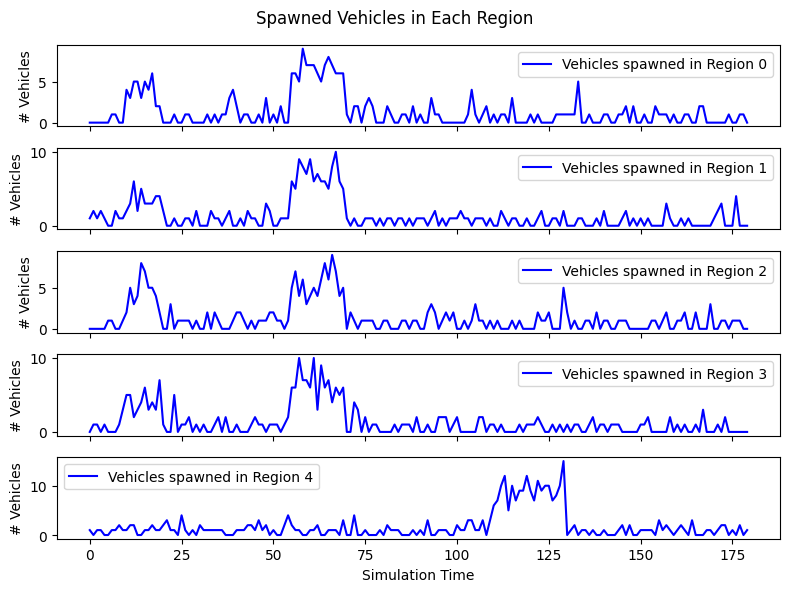

In [5]:
# the following code produces the evaluation scenario plot above
spawnedVehicles = np.load('dep/sumo_files/cocoCity/routing/spawning_evaluation.npy')
fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
for region in range(5):
    axes[region].plot(spawnedVehicles[:,region], color='blue', label = f"Vehicles spawned in Region {region}")
    axes[region].set_ylabel("# Vehicles")
    axes[region].legend()
axes[region].set_xlabel("Simulation Time")

plt.suptitle("Spawned Vehicles in Each Region")
plt.tight_layout()
plt.show()

#### How to implement a controller

As stated in the SUMO background section above, a DSL task creates a simulation object called ControlSim, which contains functionality to run the DSL traffic system simulation while continuously adjusting speed limits on specific roads with control logic that you define. A DSL task takes a ControlSim object, which you define, as an input and runs a simulation when dsl_task.runtask() is called.

The ControlSim object you define (e.g., ControlSim below) is a wrapper for the ControlSim abstract class (defined by/for the SUMO code) and must include a compute_input() function (see below for an example). The compute_input() function takes in a number of inputs (see below) as well as a controller object, which you also define. 

The Controller object you define is a wrapper for the Controller abstract class (a *different* abstract class, also defined by/for the SUMO code) and must include a get_next_input() function (see below for an example). The get_next_input() function is where you will implement the computational controllers that you develop to improve upon COCO City's controller.

To evaluate a given controller, defined for a DSL task when the task in instantiated (see below), the following command is used:
`experiment = dsl_task.runtask()`.
COCO City has built runtask() with the evaluation data set which they use to determine the quality of a given controller. This evaluation data set is similar to the training data provided above, but slightly different and more challenging. Specifically, the training data set leads to gridlock when no control is used. See the demonstration below. Note, the evaluation data should not be used to train a new controller. Rather, the training data (above) should be used.

The code below shows how noControl, which applies the nominal input (DSL of 1), performs on the evaluation set. Notice that at the end of the simulation, the central region is gridlocked and no flow occurs.

In [6]:
class noControl_controller(Controller):
    def __init__(self,actuators,params = {}) -> None:
        '''Initialize the controller'''
        super().__init__(actuators=actuators, params=params)
        self.name='noControl_controller'
        self.example = params['Example']
        
    def get_next_input(self):
        '''
        [CONTROLLER DESCRIPTION]
        -------------------------------
        Inputs: IMPLEMENT
        Outputs: IMPLEMENT
        '''
        u = np.ones(5) # one input for each DSL
        y = np.zeros(5) # one output prediction for each region
        return u, y 
    
class ControlSim(ControlSim):
    def __init__(self,network,taskparams,actuators,controlparams = {}):
        super().__init__(network=network,taskparams=taskparams,actuators=actuators,controlparams=controlparams)

    def compute_input(self, k, forecast, controller, controller_name, 
                      uAppliedMatrix, yMeasuredMatrix, ySingleStepPredMatrix, m, p, rho_opt, u_min, u_max):
        '''
        Compute the input for the controller.

        This function is called "under the hood" of an Unjam traffic simulation/a dsl_task. Thus, the inputs to compute_input are provided automatically. 
        
        COCO City has set up the code so that the following inputs are provided to compute_input for you:
        - forecast, which provides the forecast of the spawned vehicles to be used for predictive control (though some engineering is required to produce y_future), 
        - uAppliedMatrix and yMeasuredMatrix are the matrices of inputs and outputs filled in over the course of a simulation. They can be used as the lead-in data for a data-driven controller (though some engineering is required).
        - ySingleStepPredMatrix is the matrix of single step predictions ySingleStepPred, filled in over the course of a simulation.
        -------------------------------
        **Inputs:
        k: int, discrete time step (each discrete time step corresponds to 20 seconds of wall-clock time)
        forecast: np.array, forecast of spawned vehicles from all 5 regions (including center region) to the center region
        controller: Controller, controller object, defined separately
        controller_name: str, name of the controller
        uAppliedMatrix: np.array, memory of applied control inputs (zeros for timesteps that have not occurred yet)
        yMeasuredMatrix: np.array, memory of outputs (zeros for timesteps that have not occurred yet)
        ySingleStepPredMatrix: np.array, memory of single-step predicted outputs (zeros for timesteps that have not occurred yet)
        m: int, number of actuators
        p: int, number of outputs (1 per region)
        rho_opt: np.array((5,)), optimal density for each of the 5 regions
        u_min: np.array, minimum control input for each actuator (0.5)
        u_max: np.array, maximum control input for each actuator (1.5)
        -------------------------------
        **Returns:
        uApplied: np.array, control input for each actuator (5 actuators) (automatically put into uAppliedMatrix)
        ySingleStepPred: np.array, predicted density for each region (5 regions) (automatically put into ySingleStepPredMatrix)
        '''
        
        if controller_name == 'noControl_controller':
            uApplied, ySingleStepPred = controller.get_next_input()
        elif controller_name == 'anotherMethod_controller':
            pass # implement controller 
        
        return uApplied, ySingleStepPred
        


#### Defining control parameters

When you instatiate a controller, you pass the controller parameters in the form of a dictionary (see {'Example': 5} below).

These parameters include, for example the control cost and regularization parameters.

The parameters may also include the dynamics matrices for the model-based controller, as well as the data driven predictor (Hankel matrix for DeePC, Transient Predictor for TPC) for data-driven controllers.


In [7]:
# for the no control case, no parameters are needed. Below is just an example of how a parameter could be set.
noControl_control_params = {'Example': 5}

In [8]:
# takes around 30s to run
dsl_task = DSL(taskparams, ControlSim) # DSL is a class with a "runtask" function, "dsl_task" is an instance of the class

experiment = dsl_task.runtask(init_from_notebook=True, controller_class=noControl_controller, controller_json=noControl_control_params) 
# this line will instantiate a SUMO simulation and the specified controller
# The controller is determined by "controller_class" and the parameters are determined by "controller_json"
# runtask starts SUMO (the traffic sim)
# "experiment" is the saved output of the simulation

Running Simulation...
 Retrying in 1 seconds


/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:198: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (3ms ~= 333.33*RT, ~400000.00UPS, TraCI: 347ms, vehicles TOT 1619 ACT 1200 B
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!


#### Controller evaluation tools

COCO City has provided you with the `Comparison` package to evaluate the performance of controllers. The `Comparison` package includes 

`plot_density()`, 

`plot_flow()`, 

`plot_input()`, and

`plot_metrics()`, which plots the total CO2 emissions, travel time for all vehicles, waiting time for all vehicles, and the number of vehicles which successfully reached their destination.

Additionally and optionally, you have access to the `Experiment` package to load a previously saved simulation using the function `load(output_dir)`. An example of how this can be used is included below. Note that the default output directory of a simulation (`/out/cocoCity/cocoCity/`) will be overwritten at the next experiment. Therefore, if you wish to use previously saved results you are encouraged to copy the output folder and rename it.

COCO City has also provided you with GIF-generating code to visualize the road congestion/densities over the course of a simulation.

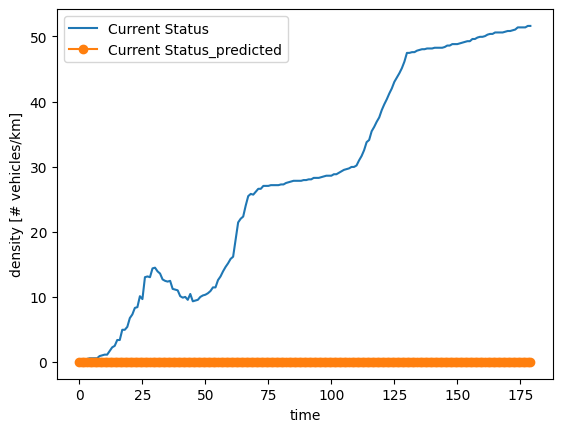

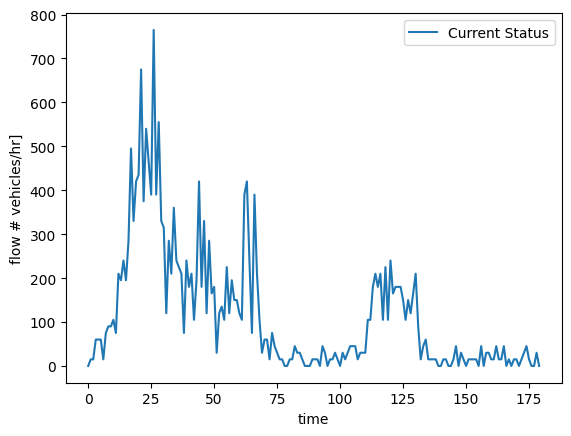

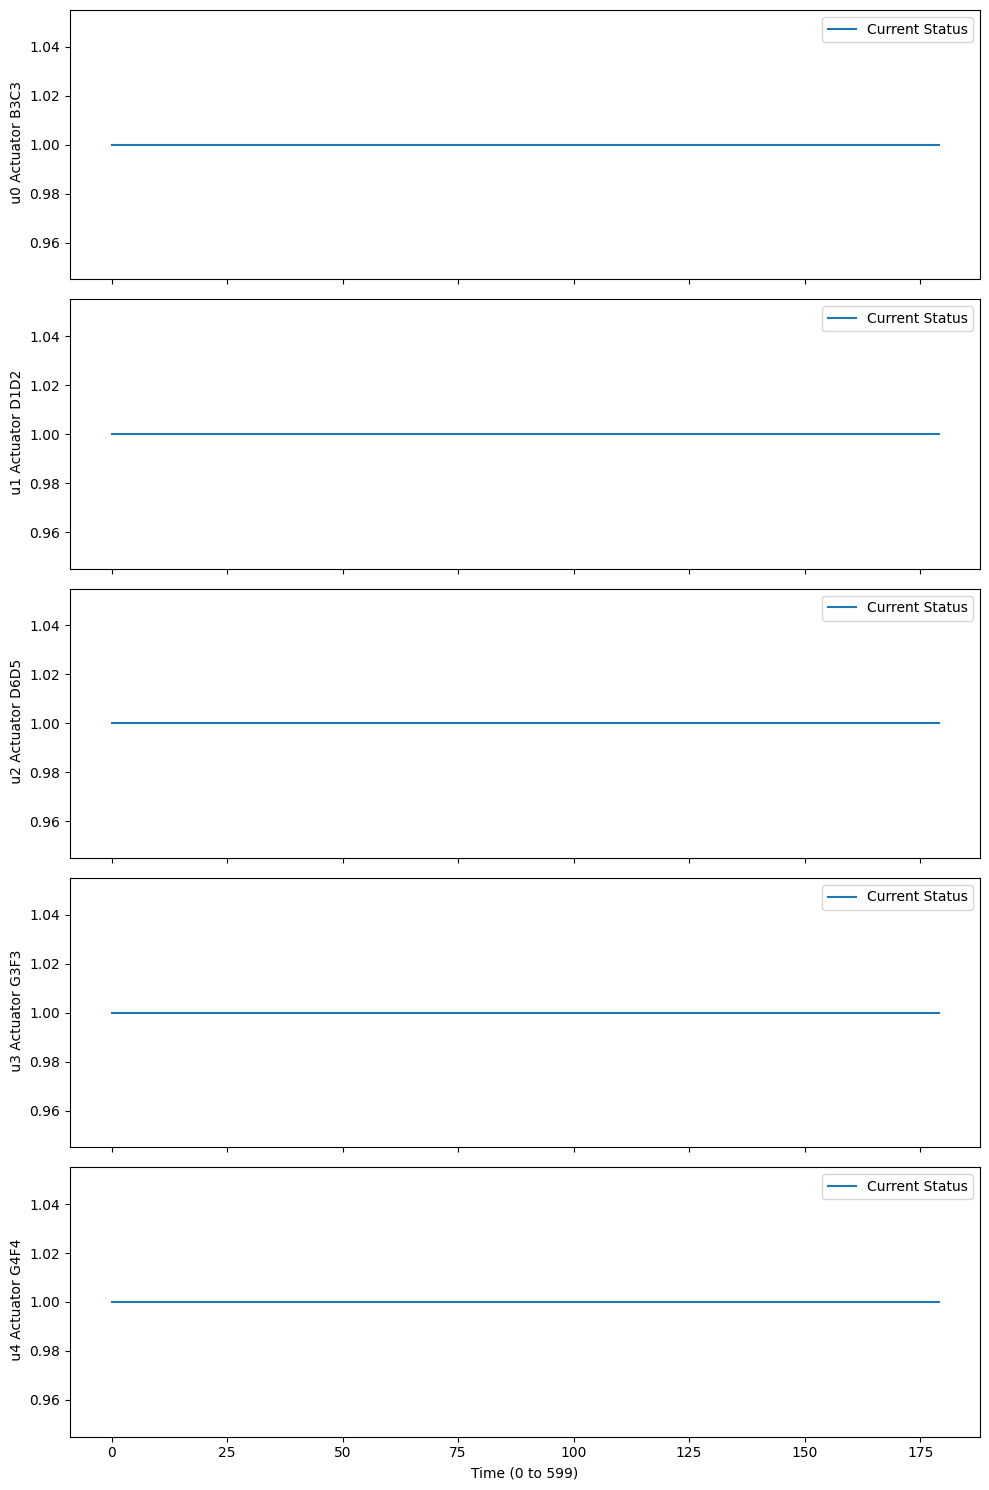

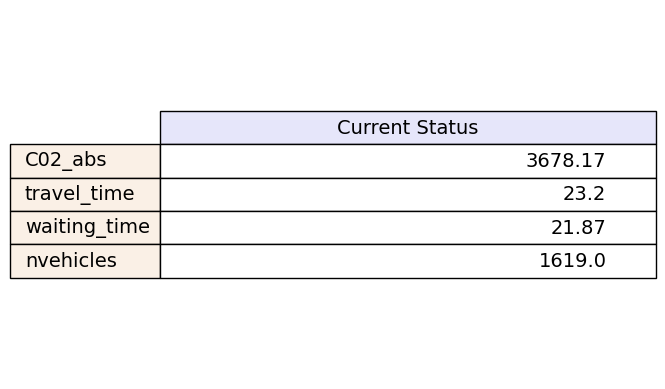

In [9]:
region = 'Region 4'
com = Comparison([experiment], ['Current Status'], region=region)

com.plot_density()
com.plot_flow()
com.plot_input()
com.plot_metrics()

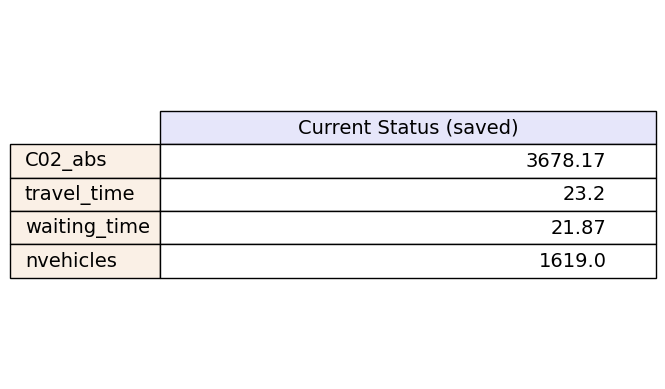

In [10]:
## Alternatively, if you have the saved output_dir, you can also plot the results.
output_dir = experiment.info['output_path']  # This is where the output of the experiment was saved.
experiment_saved = Experiment() # instantiate an empty experiment
experiment_saved.load(output_dir) # Load in the simulation experiment result
com = Comparison([experiment_saved], ['Current Status (saved)'], region=region)
com.plot_metrics()

All 100 images saved to ./out/cocoCity/cocoCity//img
GIF saved as figs/no_control_demo_heatmap.gif


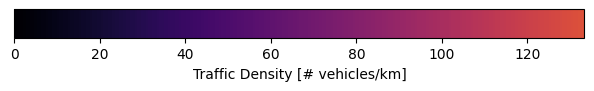

In [11]:
# GIF Generation
# [DO NOT TOUCH THE LINE BELOW] Turns off matplotlib in-line plotting to save memory, needed for GIF generation.
%matplotlib agg 

# This takes around 2 minutes (can be commented out)
# (if generated, the gif can also be saved so that it does not have to be generated new each time, or turned off for faster prototyping)
output_dir = experiment.info['output_path'] # This is where the output of the experiment was saved.
output_gif_path = "figs/no_control_demo_heatmap.gif"   # Specify where to save the density git file, can change to your own path
cmap, norm = cocoCity_plot_generate_density_gif(output_dir, output_gif_path) 

# Display saved GIF
# [DO NOT TOUCH THE LINE BELOW] turns matplotlib in-line back on.
%matplotlib inline
display(Image(url=output_gif_path))
plot_color_legend(cmap, norm)

#### COCO City's current status: P control

COCO City currently is running a P controller which keeps the density in the center region close to the optimal density by adjusting the DSLs proportionally to the error between the center-region density and the optimal density. The following block diagram describes how $\rho$ feedback loop is used to adjust the DSLs by the COOC City P control.

<img src="figs/COCOcity_pController.png" width="600">

The factor that multiplies 50 km/h for each road is $u = 1 + K_p e$, where $e = \rho_4 - \rho_4^*$. The max $u$ is 1.5, corresponding to 75 km/h, and the minimum speed limit is 0.5, corresponding to 25 km/h. That is, the speed for each DSL is $50 + 50 K_p (\rho_4 - \rho_4^*)$, clipped at 25 and 75 km/h.

The P control is demonstrated below.

Running Simulation...
 Retrying in 1 seconds


/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:198: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (1ms ~= 1000.00*RT, ~645000.00UPS, TraCI: 180ms, vehicles TOT 1678 ACT 645 B
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!


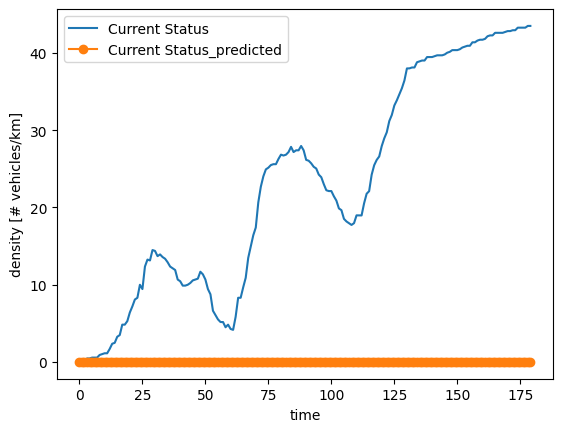

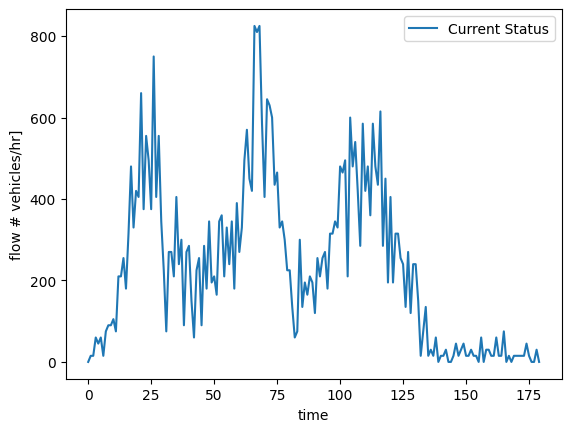

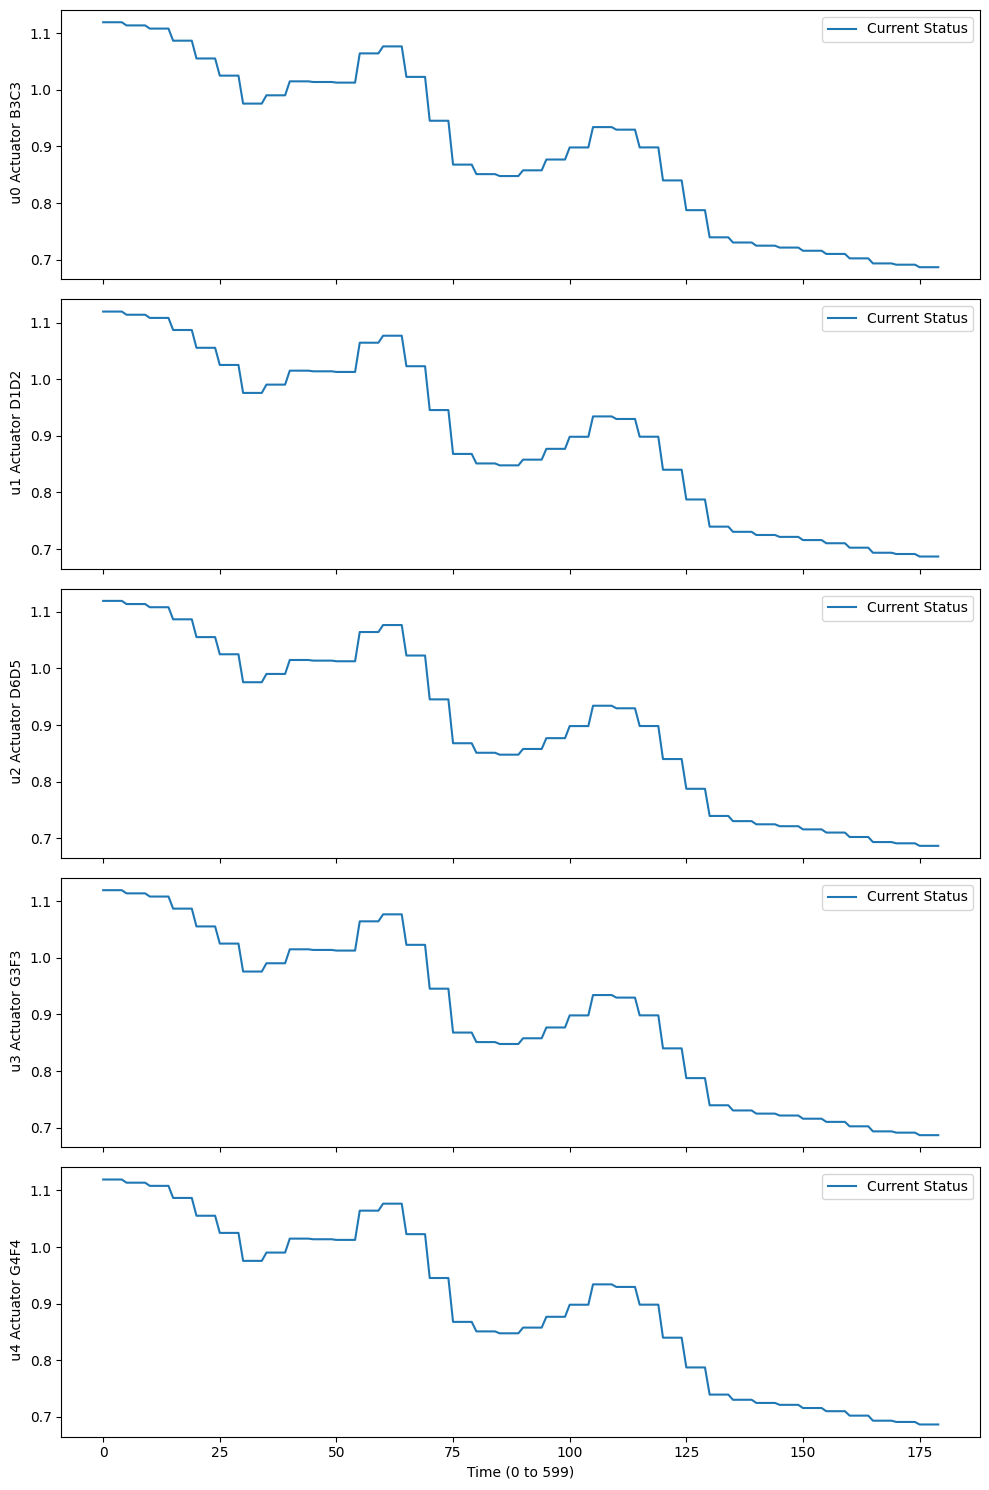

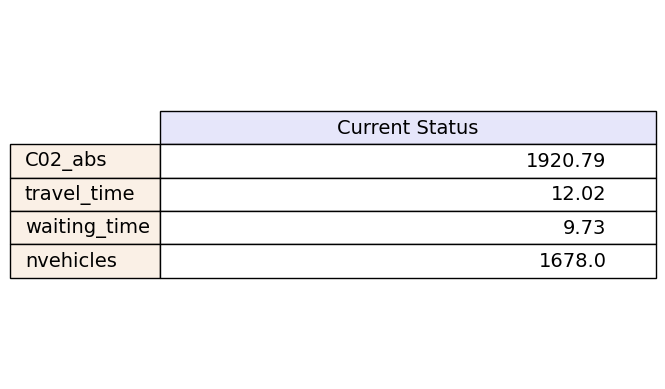

In [12]:
# First, the P controller and the ControlSim is built

class pController(Controller):  
    def __init__(self,actuators,params={}) -> None:
        '''Initialize the controller'''
        super().__init__(actuators,params)
        self.name='P'
        self.n_regions = params['n_regions']
    
        self.ul = self.safety[0] # lower bound on the input = 0.5
        self.uu = self.safety[1] # upper bound on the input = 1.5
    
        self.Kp = params['Kp']
    
    def get_next_input(self, n, target_region, r):
        '''Derive and check the inputs from the optimization
        Args:
            n: Current densities
            T: Current time
        Returns:
            Next inputs 
        '''
        self.r = r.copy()
        target_region_index = target_region - 1
        n = n.copy()[target_region_index]
        r = self.r.copy()[target_region_index]
    
        error = r - n
        u = 1 + self.Kp * error
    
        u = np.clip(u, self.ul, self.uu)
        
        return np.tile(u, 5)


class pControl_ControlSim(ControlSim):
    def __init__(self,network,taskparams,actuators,controlparams = {}):
        super().__init__(network=network,taskparams=taskparams,actuators=actuators,controlparams=controlparams)

    def compute_input(self, k, forecast, controller, controller_name, uAppliedMatrix, yMeasuredMatrix, ySingleStepPredMatrix, m, p, r, u_min, u_max):
        freq = 5
        if k % freq == 0:
            n = yMeasuredMatrix[:,k]
            target_region = 5
            u = controller.get_next_input(n, target_region, r)
            y = np.zeros(5) # No prediction, just assume it's flat
            return u, y
        else:
            return uAppliedMatrix[k-1,:], ySingleStepPredMatrix[k-1,:]




# Second, the Kp parameter is set and the P controller is simulated on the evaluation sim

pControl_control_params = {'Kp': 0.01}

dsl_task = DSL(taskparams, pControl_ControlSim) # DSL is a class with a "runtask" function, "dsl_task" is an instance of the class
controller_class = pController
controller_json = pControl_control_params
experiment = dsl_task.runtask(init_from_notebook=True, controller_class=controller_class, controller_json=controller_json)
# runtask starts SUMO (the traffic sim)
# "experiment" is the saved output of the simulation



# Third, the relevant metrics and timeseries are plotted

region = 'Region 4'
com = Comparison([experiment], ['Current Status'], region=region)

com.plot_density()
com.plot_flow()
com.plot_input()
com.plot_metrics()

As you can see in the performance metrics and density and flow timeseries above, the P controller performs better than no control but does not avoid gridlock at the end of the simulation.

# Your task

You are hired by COCO City to improve on the existing traffic control performance. 

To facilitate this, COCO City has provided you with the training data above, intended to be used with a data-driven controller, and the linearization parameters $A$, $B$, $C$, and $d$ above, intended to be used with a Model Predictive Controller.

COCO City does not know which controller will perform best, and are reliant upon you to provide a controller that improves performance and (hopefully) avoids gridlock in their downtown area.

To solve the optimization problem, we advise you to use the MOSEK solver (`problem.solve(solver=cp.MOSEK`), though you are welcome to use other solvers.
Implement your code below.

# MY WORK

## Model Based Controller



In [6]:
# First, the MPC is built

# --- 2) define MPC controller -----------------------------
class mpcController(Controller):
    def __init__(self, actuators, params):
        super().__init__(actuators, params)
        self.name      = 'MPC'
        self.n_regions = params['n_regions']
        self.ul, self.uu = self.safety           # scalar lower/upper bound
        self.beta = params.get('discount', 0.92)
        # full 5×5 dynamics
        self.A, self.B, self.C = params['A'], params['B'], params['C']
        self.d             = params['d'].flatten()
        self.N             = params['horizon']
        # build weight matrices
        self.Qmat = np.diag(params['Q'])        # 5×5 state weight
        self.Rmat = np.diag(params['R'])        # 5×5 input weight

    def get_next_input(self, n, r, spawn_seq):
        """
        n:    current density vector, shape (5,)
        r:    reference density vector, shape (5,)
        spawn_seq: predicted spawn, shape (N,5)
        returns: u0 vector, shape (5,)
        """
        # decision variables: U[0..N-1], X[0..N]
        U = cp.Variable((self.N, self.n_regions))
        X = cp.Variable((self.N+1, self.n_regions))

        cost = 0
        constr = []
        # initial‐state
        constr += [ X[0, :] == n ]

        for t in range(self.N):
            # disturbance at t
            w_t = spawn_seq[t, :]                                 # (5,)
            # full 5-dim dynamics
            constr += [
                X[t+1, :] 
                  == (self.A @ X[t, :]) 
                   + (self.B @ U[t, :]) 
                   + self.d 
                   + (self.C @ w_t)
            ]
            # input bounds
            constr += [ self.ul <= U[t, :], U[t, :] <= self.uu ]
            # stage cost
            stage_weight = self.beta**t
            cost += stage_weight * cp.quad_form(X[t+1,:] - r, self.Qmat)            
            
            cost += cp.quad_form(U[t, :] - np.ones(self.n_regions), self.Rmat)

        prob = cp.Problem(cp.Minimize(cost), constr)
        prob.solve(solver=cp.MOSEK)

        # extract first move
        u0 = U.value[0, :]   # shape (5,)
        return u0

class MPC_ControlSim(ControlSim):
    def compute_input(self, k, forecast, controller, controller_name,
                      uAppliedMatrix, yMeasuredMatrix,
                      ySingleStepPredMatrix, m, p, r, u_min, u_max):

        freq = 4
        # only re-solve every `freq` steps
        if k % freq == 0:
            n = yMeasuredMatrix[:, k]   # current densities, shape (5,)
            # build spawn window
            N   = controller.N
            seq = forecast[k : k+N, :]
            if seq.shape[0] < N:
                # use mean demand observed so far (per region)
                if k == 0:                           # no history yet
                    pad_vals = forecast[0, :]        # or np.zeros(5), or a design baseline
                else:                                # use mean of what we've seen so far
                    pad_vals = forecast[:k, :].mean(axis=0)
                pad = np.tile(pad_vals, (N - seq.shape[0], 1))  # shape (missing, 5)
                seq = np.vstack([seq, pad])

            u = controller.get_next_input(n, r, seq)
            y = controller.A @ n \
                + controller.B @ u \
                + controller.d \
                + controller.C @ seq[0, :]
            return u, y
        else:
            # hold previous speed limits
            return uAppliedMatrix[k-1, :], ySingleStepPredMatrix[k-1, :]



Evaluation

In [23]:
# Second, Parameters and simulation

mpc_params = {
    'n_regions': 5,
    'A':          A,
    'B':          B,
    'C':          C,
    'd':          d,
    'horizon':    200,
    'Q':        [1.2,1,1,1,10],
    'R':      [0.01,0.01,0.01,0.01,0.01],
    'discount': 0.97
}
dsl_task = DSL(taskparams, MPC_ControlSim) # DSL is a class with a "runtask" function, "dsl_task" is an instance of the class
controller_class = mpcController
experiment = dsl_task.runtask(
    init_from_notebook=True,
    controller_class=mpcController,
    controller_json=mpc_params
)



Running Simulation...
 Retrying in 1 seconds


/opt/conda/envs/coco/lib/python3.13/site-packages/traci/main.py:198: UserWarning: API change now handles step as floating point seconds
  connection.check().simulationStep(step)


Step #3580.00 (1ms ~= 1000.00*RT, ~463000.00UPS, TraCI: 96ms, vehicles TOT 1699 ACT 463 BU
Simulation successful
Saving experiment results to ./out/cocoCity/cocoCity/. This directory can be copied and renamed if you want to retain the results, otherwise it will be overwritten during the next experiment!


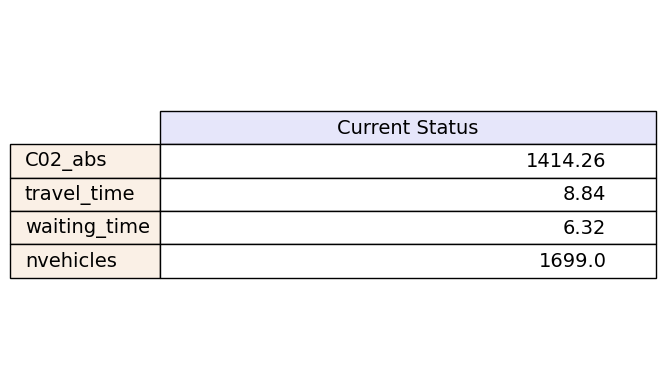

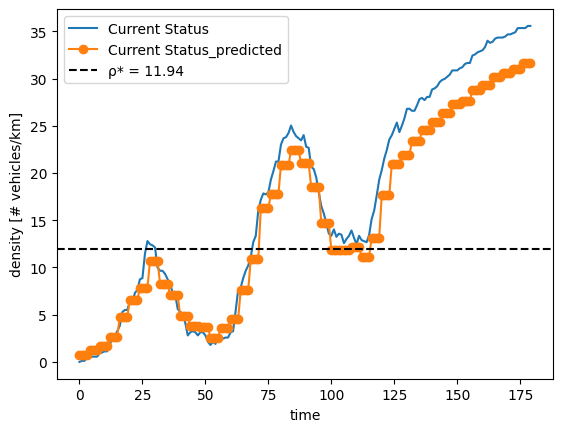

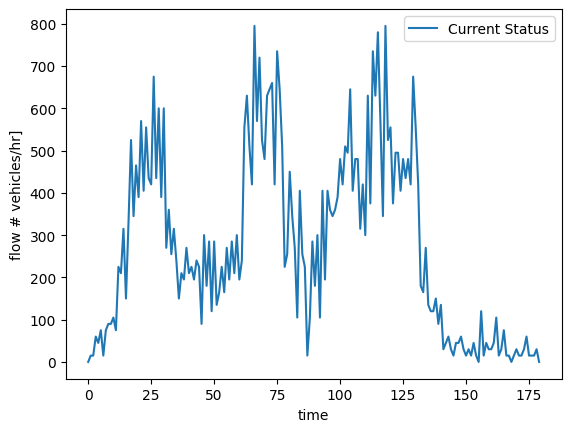

Region 0


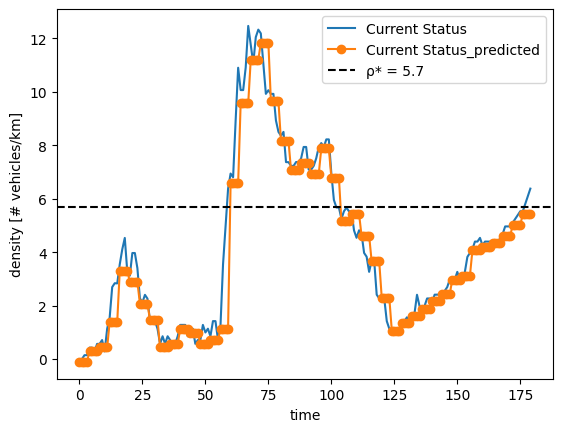

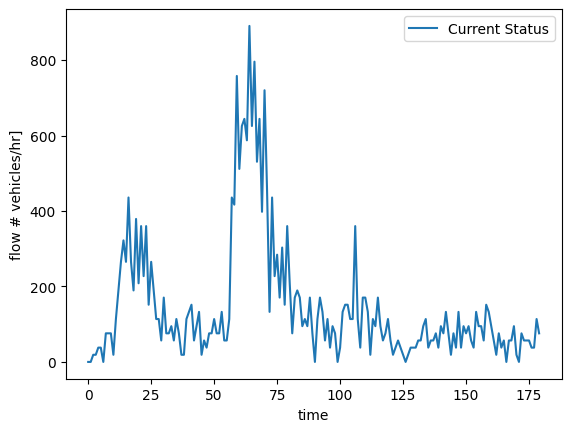

Region 1


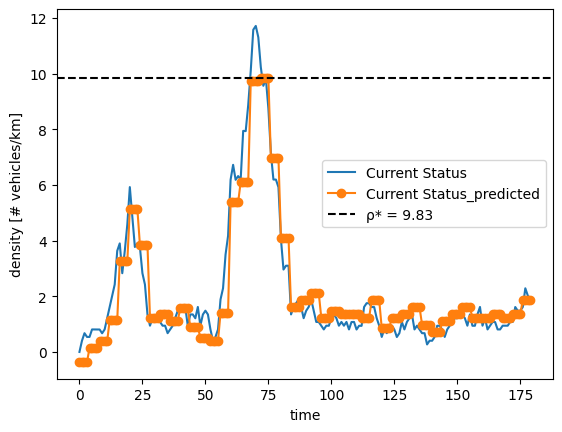

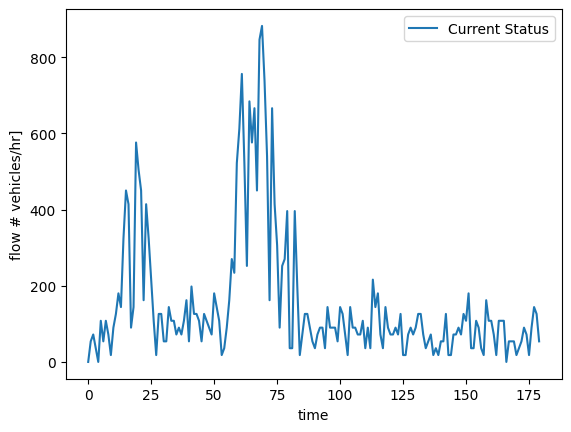

Region 2


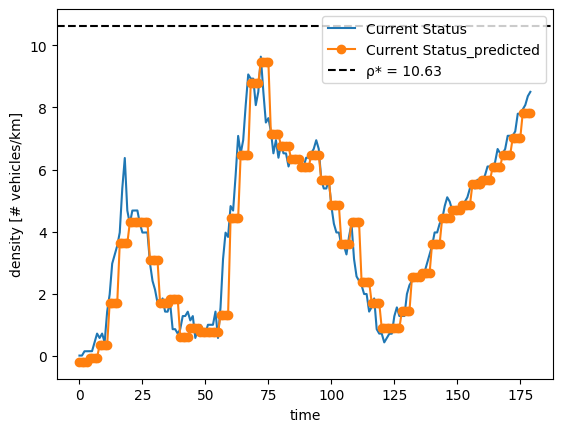

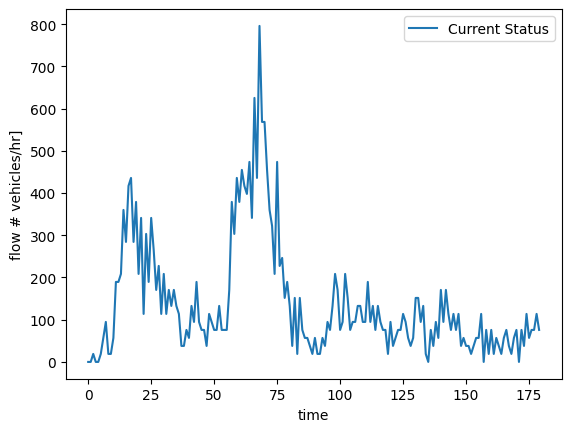

Region 3


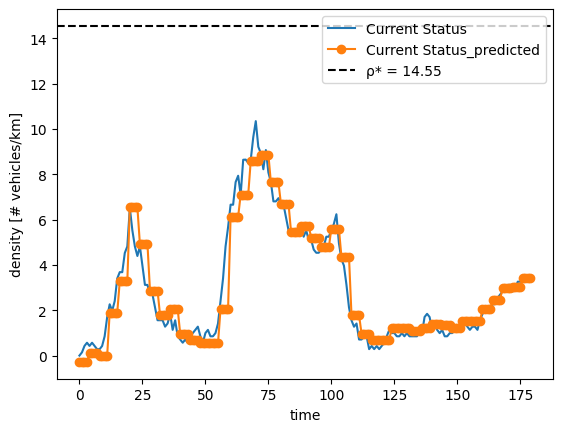

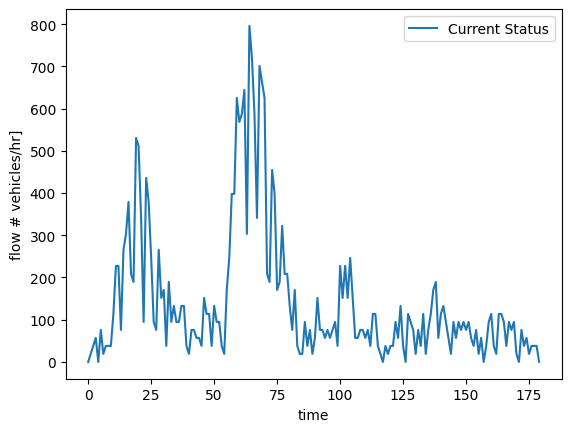

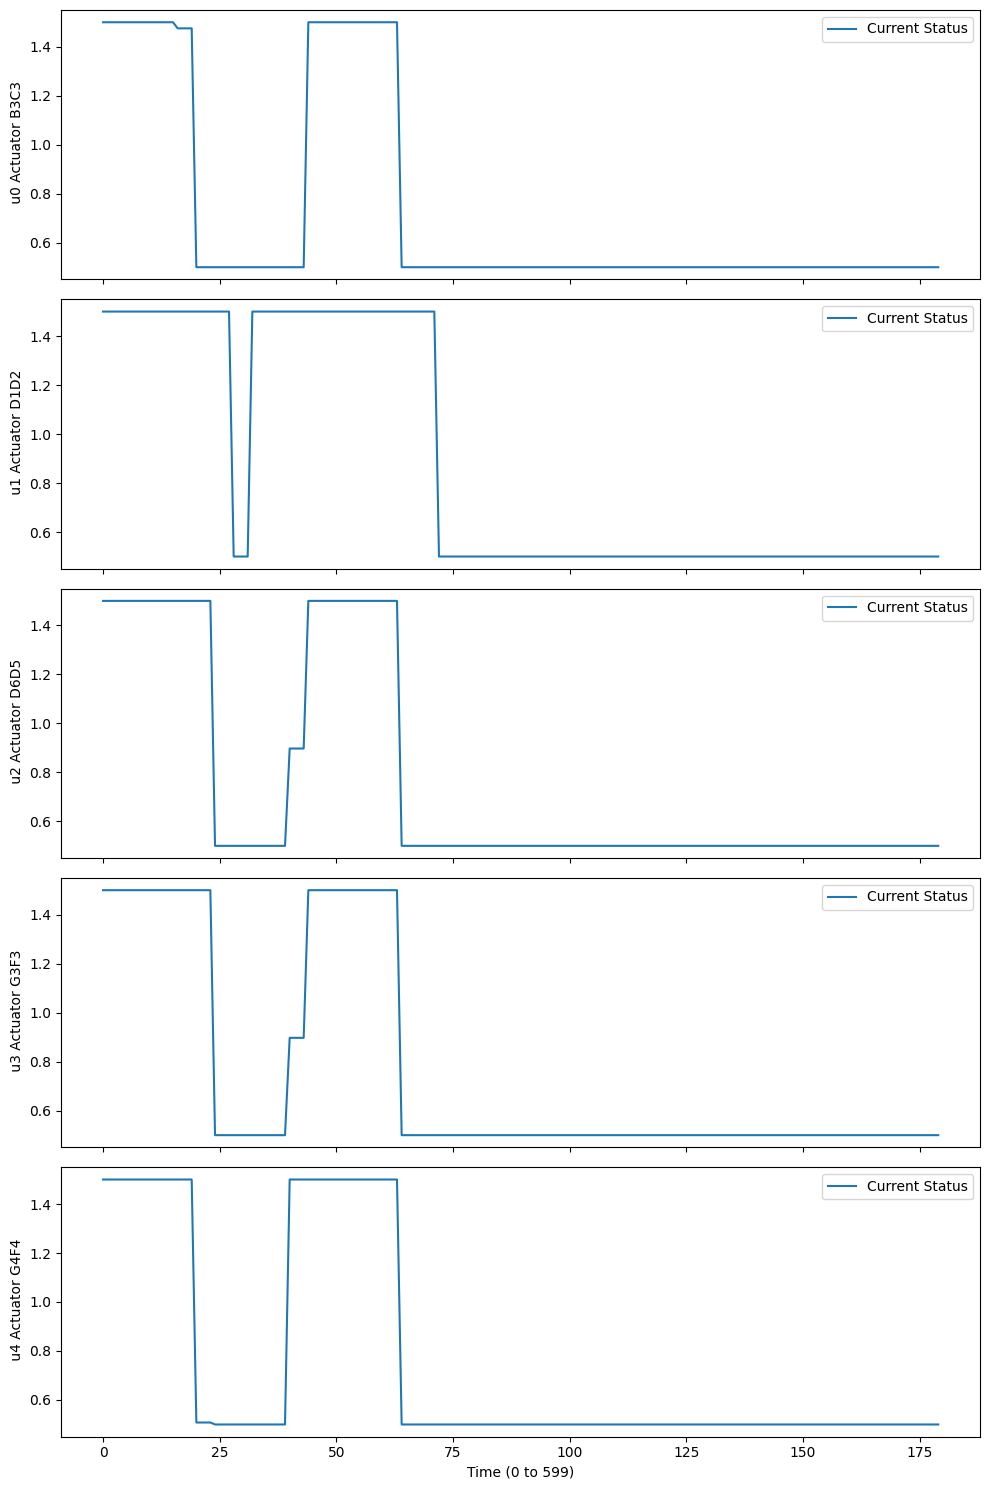

In [24]:
# Third, the relevant metrics and timeseries are plotted

region = 'Region 4'
com = Comparison([experiment], ['Current Status'], region=region, rho=11.94)
com.plot_metrics()

com.plot_density()
com.plot_flow()


print("Region 0")
region = 'Region 0'
com = Comparison([experiment], ['Current Status'], region=region, rho=5.7)
com.plot_density()
com.plot_flow()

print("Region 1")
region = 'Region 1'
com = Comparison([experiment], ['Current Status'], region=region, rho=9.83)
com.plot_density()
com.plot_flow()

print("Region 2")
region = 'Region 2'
com = Comparison([experiment], ['Current Status'], region=region, rho=10.63)
com.plot_density()
com.plot_flow()

print("Region 3")
region = 'Region 3'
com = Comparison([experiment], ['Current Status'], region=region, rho=14.55)
com.plot_density()
com.plot_flow()

com.plot_input()



# Data Driven Controller

## DeePC

In [65]:
# deePC_controller.py
"""DeePC (Data‑enabled Predictive Control) implementation for the COCO City
traffic‑density regulation task.

The controller keeps  the centre region near **rho_star**
while secondarily regulating the other four regions.  It follows the
mathematical formulation in the DeePC lecture notes you supplied, but wraps it
in the same class structure as the existing P and no‑control controllers so it
can be plugged straight into your simulation harness.

Key defaults (all overridable via the ``params`` dict):
    * Lp = 20 — past (initial) window length  ≈ 400 s
    * Lf = 12 — prediction horizon           ≈ 240 s
    * Q  = diag([1, 1, 1, 1, 10])
    * R  = 0.01·I₅ (but only used for numerical regularisation)
    * λg = 1e‑3, λy = λu = 1e‑4  — Tikhonov regularisation
    * u bounds = [0.5, 1.5]

"""

# -----------------------------------------------------------------------------
# Helper functions
# -----------------------------------------------------------------------------

def build_hankel(data: np.ndarray, depth: int) -> np.ndarray:
    """
    data: shape (n_signals, T)
    depth: horizon length (T_past + T_fut)
    returns: shape (n_signals*depth, T-depth+1)
    """
    n, T = data.shape
    N = T - depth + 1
    if N <= 0:
        raise ValueError(f"T={T} < depth={depth}")
    H = np.zeros((n*depth, N))
    for i in range(N):
        H[:, i] = data[:, i : i + depth].reshape(-1)
    return H

In [66]:
# -----------------------------------------------------------------------------
# DeePC controller class
# -----------------------------------------------------------------------------

class deePCController(Controller):
    """Data-enabled Predictive Controller for COCO City."""

    def __init__(self, actuators, params):
        super().__init__(actuators=actuators, params=params)
        self.name = "deePC_controller"

        # dims
        self.m = 5    # # of inputs
        self.p = 5    # # of outputs

        # horizons
        self.Lp = params.get("Lp", 20)
        self.Lf = params.get("Lf", 12)
        self.L  = self.Lp + self.Lf

        # weights
        Q_list = params.get("Q", [1,1,1,1,10])
        R_list = params.get("R", [0.01]*self.m)
        self.Q = np.diag(Q_list)
        self.R = np.diag(R_list)

        # regularization
        self.lambda_g = params.get("lambda_g", 1e-3)
        self.lambda_y = params.get("lambda_y", 1e-4)
        self.lambda_u = params.get("lambda_u", 1e-4)

        # input bounds
        self.u_min = np.full(self.m, params.get("u_min", 0.5))
        self.u_max = np.full(self.m, params.get("u_max", 1.5))
        self.safety = (self.u_min, self.u_max)

        # --- load & build Hankel from CSV once at init ---
        df = pd.read_csv('./dep/sumo_files/cocoCity/control/edge/io_data.csv', index_col=0)
        U = df.filter(like='Speed limit factor').values    # shape (T, m)
        Y = df.filter(like='Density in Region').values     # shape (T, p)

        # transpose to (n_signals, T) then build
        self.H_u = build_hankel(U.T, self.L)  # → (m*L, T-L+1)
        self.H_y = build_hankel(Y.T, self.L)  # → (p*L, T-L+1)


    def get_next_input(self,
                       u_hist: np.ndarray,
                       y_hist: np.ndarray,
                       r: np.ndarray):
        """
        Public API: called each time-step by the simulator.
        u_hist: (k, m), y_hist: (k, p), r: (p,) the reference density
        """
        k = u_hist.shape[0]

        # cold start until we have Lp past points
        if k < self.Lp:
            u0 = np.ones(self.m)
            y0 = y_hist[-1] if k>0 else np.zeros(self.p)
            return u0, y0

        # build initial condition vectors
        u_p = u_hist[-self.Lp : , :].T.reshape(-1)  # (m*Lp,)
        y_p = y_hist[-self.Lp : , :].T.reshape(-1)  # (p*Lp,)
        r_block = np.tile(r, self.Lf)               # (p*Lf,)

        # solve the DeePC QP
        u_fut, y_fut = self._solve_deepc(u_p, y_p, r_block)

        # return only the first-step
        u0 = u_fut[:self.m]
        y0 = y_fut[:self.p]
        return u0, y0


    def _solve_deepc(self, u_p, y_p, r_block):
        """Set up and solve the CVXPY problem."""
        m, p, Lp, Lf = self.m, self.p, self.Lp, self.Lf

        # partition Hankel
        U_p = self.H_u[0 : m*Lp, :]
        U_f = self.H_u[m*Lp :   , :]
        Y_p = self.H_y[0 : p*Lp, :]
        Y_f = self.H_y[p*Lp :   , :]

        # decision vars
        g   = cp.Variable(U_p.shape[1])
        u_f = cp.Variable(m * Lf)
        y_f = cp.Variable(p * Lf)

        # cost blocks
        Qblk = np.kron(np.eye(Lf), self.Q)
        Rblk = np.kron(np.eye(Lf), self.R)
        cost = (
            cp.quad_form(y_f - r_block, Qblk)
            + self.lambda_g * cp.sum_squares(g)
            + self.lambda_u * cp.quad_form(u_f, Rblk)
            + self.lambda_y * cp.sum_squares(y_f)
        )

        # constraints
        constraints = [
            U_p @ g == u_p,
            Y_p @ g == y_p,
            U_f @ g == u_f,
            Y_f @ g == y_f,
            u_f >= np.tile(self.u_min, Lf),
            u_f <= np.tile(self.u_max, Lf),
        ]

        prob = cp.Problem(cp.Minimize(cost), constraints)
        prob.solve(solver=cp.MOSEK)

        if prob.status not in (cp.OPTIMAL, cp.OPTIMAL_INACCURATE):
            raise RuntimeError(f"DeePC optimisation failed: {prob.status}")

        return u_f.value, y_f.value

In [67]:
class deePC_ControlSim(ControlSim):
    """
    Thin wrapper: delegate the heavy lifting to the controller’s `get_next_input`.
    """

    def compute_input(
        self,
        k,
        forecast,
        controller,
        controller_name,
        uAppliedMatrix,
        yMeasuredMatrix,
        ySingleStepPredMatrix,
        m,
        p,
        rho_opt,
        u_min,
        u_max,
    ):
        """
        Called at every sim step by the COCO City infrastructure.

        Here we just build the histories and forward them to the controller.
        """
        u_hist = uAppliedMatrix[:k, :]
        y_hist = yMeasuredMatrix[:k, :]

        u0, y0 = controller.get_next_input(u_hist, y_hist, rho_opt)
        # ensure y0 is 1D of length p
        y0 = np.array(y0).flatten()[:p]
        return np.array(u0).flatten(), y0

In [68]:
# Parameters and simulation

deePC_params = {
    'Lp':             20,
    'Lf':             20,
    'Hankel_cols':    60,
    'lambda_g':       1e-3,
    'lambda_y':       1e-4,
    'lambda_u':       1e-4,
    'Q':        [1.2,1,1,1,10],
    'R':      [0.01,0.01,0.01,0.01,0.01]
}
dsl_task = DSL(taskparams, deePC_ControlSim) # DSL is a class with a "runtask" function, "dsl_task" is an instance of the class
controller_class = deePCController
experiment = dsl_task.runtask(
    init_from_notebook=True,
    controller_class=deePCController,
    controller_json=deePC_params
)



Running Simulation...
 Retrying in 1 seconds


Error occurred during simulation: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (100,) and arg 1 with shape (900,).
Step #400.00 (0ms ?*RT. ?UPS, TraCI: 62ms, vehicles TOT 273 ACT 210 BUF 1)                


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (100,) and arg 1 with shape (900,).